#Clase 1

Se crean dos clases. La clase integrador que debería contar con, idealmente, múltiples métodos de integración para trayectoria de partículas. En este caso solo está implementado PEFRL, un algortimo de dinámica molecular. La clase partícula, tiene todo lo necesario para que se puede representar una partícula básica moviendose en el espacio. La fuerza entre partículas está dada por la ley de gravitación universal. Luego se ejemplifica como usar el código. Para propagar el sistema, como partícula es sub clase del integrador, basta con que una sola partícula llame a la función que hace el paso de tiempo. También se podría crear una instancia del integrador que lo haga, pero es particularmente útil que la partícula pueda hacer la integración, así, las partículas potencialmente podrían integrarse con distintos métodos numéricos según sea necesario. En el ejemplo, se ve un sistema binario en el que el centro de masa se mueve en dirección del eje z. 

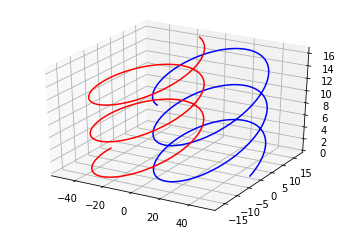

In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt

class integrator:
  def calculate_forces(self,array):
    for i in array: i.delete_force()

    for i in range(len(array)):
      for j in range(i+1,len(array)):
        R = np.linalg.norm(array[i].Get_r()-array[j].Get_r())**3
        F = np.multiply(array[i].Get_r()-array[j].Get_r(),-array[i].Get_m()*array[j].Get_m()/R)
        array[i].add_force(F)
        array[j].add_force(-1*F) # 3 ley de Newton

  def pefrl_time_step(self,array,dt):
    E=0.1786178958448091e00
    L=-0.2123418310626054e0
    X=-0.6626458266981849e-1
    coe1=(1-2*L)/2
    coe2=(1-2*(X+E))*2/2
    for i in array: i.move_r(dt,E)
    self.calculate_forces(array) 
    for i in array: i.move_v(dt,coe1)
    for i in array: i.move_r(dt,X)
    self.calculate_forces(array) 
    for i in array: i.move_v(dt,L)
    for i in array: i.move_r(dt,coe2)
    self.calculate_forces(array) 
    for i in array: i.move_v(dt,L)
    for i in array: i.move_r(dt,X)
    self.calculate_forces(array) 
    for i in array: i.move_v(dt,coe1)
    for i in array: i.move_r(dt,E)

class particle(integrator):
  r = np.array([0.0,0.0,0.0])
  v = np.array([0.0,0.0,0.0])
  F = np.array([0.0,0.0,0.0])
  m = 1.0
  def __init__(self, r0, v0, m0):
    self.r = r0
    self.v = v0
    self.m = m0
  def add_force(self,Force):
    self.F+=Force
  def delete_force(self):
    self.F = np.array([0.0,0.0,0.0])
  def move_r(self,dt,cte):
    self.r += np.multiply(self.v,dt*cte)
  def move_v(self,dt,cte):
    self.v += np.multiply(self.F,dt*cte/self.m)
  def Get_r(self):
    return self.r 
  def Get_x(self):
    return self.r[0]
  def Get_y(self):
    return self.r[1]
  def Get_z(self):
    return self.r[2]
  def Get_v(self):
    return self.v
  def Get_m(self):
    return self.m


#Initial conditions
r10 = np.array([50.0,0.0,0.0])
r20 = np.array([-50.0,0.0,0.0])

v10 = np.array([0.0,1.0,0.2])
v20 = np.array([0.0,-1.0,0.0])
m1 = 1000.0
m2 = 1000.0
dt = 0.01
tmax = 150.0

#list of particles
bodys=[particle(r10,v10,m1), particle(r20,v20,m2)]
coords = []

for t in np.arange(0, tmax, dt):
  bodys[0].pefrl_time_step(bodys,dt)
  coords.append([bodys[0].Get_x(), bodys[0].Get_y(), bodys[0].Get_z(), bodys[1].Get_x(), bodys[1].Get_y(),  bodys[1].Get_z()])


co = np.asanyarray(coords)
ax = plt.axes(projection='3d')
ax.plot3D(co[:,0], co[:,1], co[:,2], 'b')
ax.plot3D(co[:,3], co[:,4], co[:,5], 'r')
plt.show()

  


#Clase 2

En un curso de inteligencia artificial que hice, nos pusieron de tarea hacer un algoritmo de python que sea capaz de resolver un laberinto dado en un archivo.txt. A continuación presento una versión más sencilla que cuenta con dos algorithmos distintos para encontrar la solución. El contenido del archivo debe ser algo así

```
#####B#
##### #
####  #
#### ##
     ##
A######
```

Donde A es el inicio y B el final. Los \# son paredes. 


#Código laberinto

In [ ]:
import sys

class Node():
    def __init__(self, state, parent, action):
        self.state = state
        self.parent = parent
        self.action = action


class StackFrontier():
    def __init__(self):
        self.frontier = []

    def add(self, node):
        self.frontier.append(node)

    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[-1]
            self.frontier = self.frontier[:-1]
            return node


class QueueFrontier(StackFrontier):

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = self.frontier[0]
            self.frontier = self.frontier[1:]
            return node

class Maze():

    def __init__(self, filename):

        # Read file and set height and width of maze
        with open(filename) as f:
            contents = f.read()

        # Validate start and goal
        if contents.count("A") != 1:
            raise Exception("maze must have exactly one start point")
        if contents.count("B") != 1:
            raise Exception("maze must have exactly one goal")

        # Determine height and width of maze
        contents = contents.splitlines()
        self.height = len(contents)
        self.width = max(len(line) for line in contents)

        # Keep track of walls
        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)
                        row.append(False)
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                    elif contents[i][j] == " ":
                        row.append(False)
                    else:
                        row.append(True)
                except IndexError:
                    row.append(False)
            self.walls.append(row)

        self.solution = None


    def print(self):
        solution = self.solution[1] if self.solution is not None else None
        print()
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if col:
                    print("█", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif solution is not None and (i, j) in solution:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()


    def neighbors(self, state):
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1))
        ]

        result = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                result.append((action, (r, c)))
        return result


    def solve(self,algorithm):
        """Finds a solution to maze, if one exists."""

        # Keep track of number of states explored
        self.num_explored = 0

        # Initialize frontier to just the starting position
        start = Node(state=self.start, parent=None, action=None)
        if algorithm=="BFS":
            frontier = QueueFrontier() 
        elif algorithm=="DFS":
            frontier = StackFrontier()
        else:
            print(algorithm+" is an unknown algortihm")
            exit()

        frontier.add(start)

        # Initialize an empty explored set
        self.explored = set()

        # Keep looping until solution found
        while True:

            # If nothing left in frontier, then no path
            if frontier.empty():
                raise Exception("no solution")

            # Choose a node from the frontier
            node = frontier.remove()
            self.num_explored += 1

            # If node is the goal, then we have a solution
            if node.state == self.goal:
                actions = []
                cells = []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                return

            # Mark node as explored
            self.explored.add(node.state)

            # Add neighbors to frontier
            for action, state in self.neighbors(node.state):
                if not frontier.contains_state(state) and state not in self.explored:
                    child = Node(state=state, parent=node, action=action)
                    frontier.add(child)


    def output_image(self, filename, show_solution=True, show_explored=False):
        from PIL import Image, ImageDraw
        cell_size = 50
        cell_border = 2

        # Create a blank canvas
        img = Image.new(
            "RGBA",
            (self.width * cell_size, self.height * cell_size),
            "black"
        )
        draw = ImageDraw.Draw(img)

        solution = self.solution[1] if self.solution is not None else None
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):

                # Walls
                if col:
                    fill = (40, 40, 40)

                # Start
                elif (i, j) == self.start:
                    fill = (255, 0, 0)

                # Goal
                elif (i, j) == self.goal:
                    fill = (0, 171, 28)

                # Solution
                elif solution is not None and show_solution and (i, j) in solution:
                    fill = (220, 235, 113)

                # Explored
                elif solution is not None and show_explored and (i, j) in self.explored:
                    fill = (212, 97, 85)

                # Empty cell
                else:
                    fill = (237, 240, 252)

                # Draw cell
                draw.rectangle(
                    ([(j * cell_size + cell_border, i * cell_size + cell_border),
                      ((j + 1) * cell_size - cell_border, (i + 1) * cell_size - cell_border)]),
                    fill=fill
                )

        img.save(filename)

#Resolver el laberinto

In [ ]:
#We Have 2 Uninformed search algorithms
#DFS Depth-First Search
#BFS Breadth-First Search
#To change between each algorithm do:
#For DFS use StackFrontier to store the states
#For BFS use QueueFrontier to store the states

m = Maze('/maze1.txt')
print("Maze:")
m.print()
print("Solving...")
algorithm="BFS"
m.solve(algorithm)
print("States Explored:", m.num_explored)
print("Solution with "+algorithm+":")
m.print()
#m.output_image("maze.png", show_explored=True)

Maze:

█████B█
█████ █
████  █
████ ██
     ██
A██████

Solving...
States Explored: 11
Solution with BFS:

█████B█
█████*█
████**█
████*██
*****██
A██████



In [ ]:
m = Maze('/maze2.txt')
print("Maze:")
m.print()
print("Solving...")
algorithm="DFS"
m.solve(algorithm)
print("States Explored:", m.num_explored)
print("Solution with "+algorithm+":")
m.print()

Maze:

███                 █████████
█   ███████████████████   █ █
█ ████                █ █ █ █
█ ███████████████████ █ █ █ █
█                     █ █ █ █
█████████████████████ █ █ █ █
█   ██                █ █ █ █
█ █ ██ ███ ██ █████████ █ █ █
█ █    █   ██B█         █ █ █
█ █ ██ ████████████████ █ █ █
███ ██             ████ █ █ █
███ ██████████████ ██ █ █ █ █
███             ██    █ █ █ █
██████ ████████ ███████ █ █ █
██████ ████             █   █
A      ██████████████████████

Solving...
States Explored: 194
Solution with DFS:

███                 █████████
█   ███████████████████   █ █
█ ████                █ █ █ █
█ ███████████████████ █ █ █ █
█                     █ █ █ █
█████████████████████ █ █ █ █
█   ██********        █ █ █ █
█ █ ██*███ ██*█████████ █ █ █
█ █****█   ██B█         █ █ █
█ █*██ ████████████████ █ █ █
███*██             ████ █ █ █
███*██████████████ ██ █ █ █ █
███****         ██    █ █ █ █
██████*████████ ███████ █ █ █
██████*████             █   █
A******███